In [1]:
import gc
import warnings
import numpy as np
import pandas as pd

# Sklearn imports
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
warnings.simplefilter(action='ignore', category=FutureWarning)
df = pd.read_csv("telcochurndata.csv")
df.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


1.1 Impute missing values
There are eleven missing values in TotalCharges for some of the customers with zero tenure. We can impute these values with zero as these customers probably haven't paied any bills yet. We can also drop the customerID, since we already have the pandas numerical index.

In [2]:
df['TotalCharges'] = df['TotalCharges'].replace(" ", 0).astype('float32')
df.drop(['customerID'],axis=1, inplace=True)

2. Preprocessing
2.1 Categorical features
The dataset has 16 categorical columns and six of them have binary values (yes or no). The approach used here is:

In binary columns, just replace values with 1 and 0
Create a new column for each value in the remaining columns (and assign 1 or 0)
This is equivalent to one-hot-encode, but we avoid some extra columns for yes and no features.

In [3]:
categorical_cols = [c for c in df.columns if df[c].dtype == 'object'
                    or c == 'SeniorCitizen']
df_categorical = df[categorical_cols].copy()
for col in categorical_cols:
    if df_categorical[col].nunique() == 2:
        df_categorical[col], _ = pd.factorize(df_categorical[col])
    else:
        df_categorical = pd.get_dummies(df_categorical, columns=[col])

df_categorical.head(3)

,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,Churn,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,0,0,0,0,0,False,True,False,...,True,False,False,True,False,False,False,False,True,False
1,1,0,1,0,1,1,0,True,False,False,...,True,False,False,False,True,False,False,False,False,True
2,1,0,1,0,1,0,1,True,False,False,...,True,False,False,True,False,False,False,False,False,True


2.2 Feature scalling
There are three numerical columns with the following distributions:

In [4]:
def distplot(feature, frame, color='g'):
    plt.figure(figsize=(8,3))
    plt.title("Distribution for {}".format(feature))
    ax = sns.distplot(frame[feature], color= color)

numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[numerical_cols].describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734375
std,24.559481,30.090047,2266.794434
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,398.549988
50%,29.000000,70.350000,1394.550049
75%,55.000000,89.850000,3786.599976
max,72.000000,118.750000,8684.799805


/tmp/ipykernel_70758/1414074950.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(frame[feature], color= color)
/tmp/ipykernel_70758/1414074950.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(frame[feature], color= color)
/tmp/ipykernel_70758/1414074950.py:4: UserWarning: 

`dist

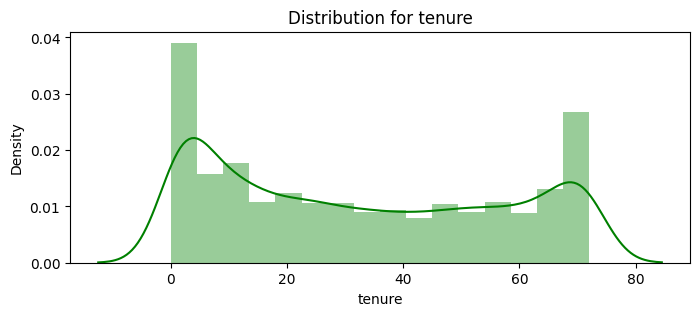

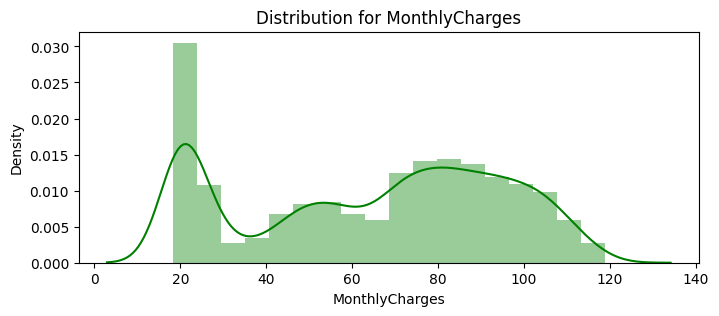

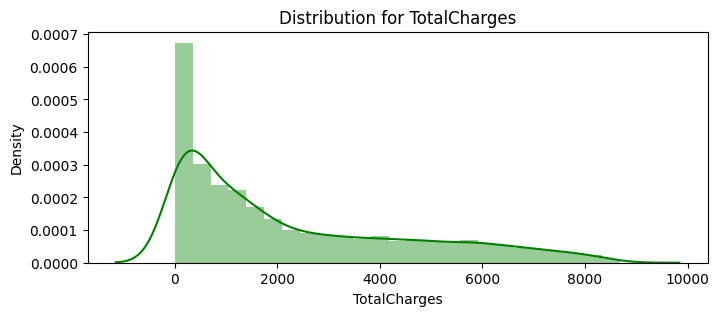

In [5]:
for feat in numerical_cols: distplot(feat, df)

Standardization

I've tryed a few experiments using the raw numerical features, normalization and standardization and found that the former yelds slightly better results. Altough we are not using gradient based optimization, the features have very distinct ranges and that can be detrimental to the model. I also think that the values are distributed over a long interval as we can see in the plots above, so restricting them to [0, 1] range with normalization is not the best approach.

/tmp/ipykernel_70758/1414074950.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(frame[feature], color= color)
/tmp/ipykernel_70758/1414074950.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(frame[feature], color= color)
/tmp/ipykernel_70758/1414074950.py:4: UserWarning: 

`dist

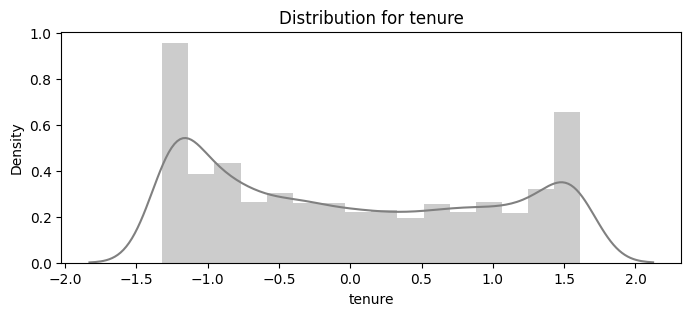

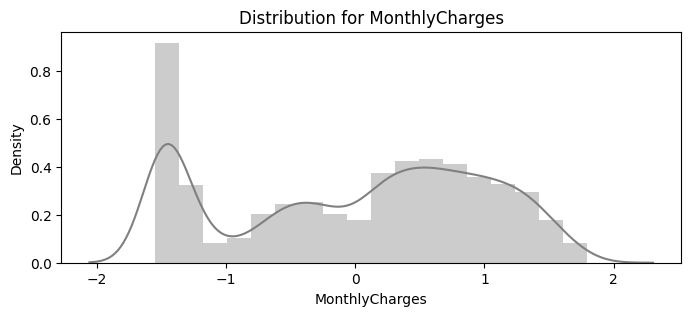

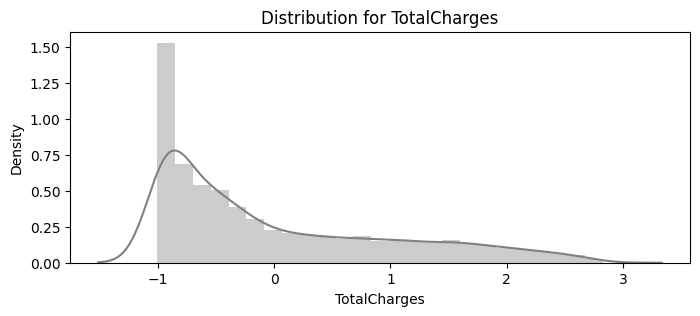

In [6]:
df_std = pd.DataFrame(StandardScaler().fit_transform(df[numerical_cols].astype('float64')),
                       columns=numerical_cols)
for feat in numerical_cols: distplot(feat, df_std, color='gray')

3. Cross-Validation
In order to test the efficiency of our classifier we need to split the data in a train and test set, so we can evaluate our model in data that it has never seen before. However, when evaluating different features, transformations and hyperparameters for estimators there is a risk of overffiting on the test set. To solve this problem, yet another part of the dataset can be held out as a validation set, but we drastically reduce the number of samples which can be used for learning.

As we only have seven thousands samples, our solution needs a procedure called cross-validation for training and validation. After that, we can evaluate our final model on the test set. For more information about cross-validation check the Sklearn reference.

Let's create a class that will use GridSearchCV and KFold to find the best hyperparameters and return the cross-validation score. The second method will also train the classifier with the best hyperparameters found and predict the test set.

In [7]:
class Model():
    def __init__(self, classifier, frame, metrics, fixed_params = {},
                 test_size=0.2, random_seed=50):
        self.estimator = classifier
        self.seed = random_seed
        self.metrics = metrics
        self.hyperparameters = {}
        self.fixed_params = fixed_params
        self.fixed_params['random_state'] = random_seed
        if classifier == KNeighborsClassifier:
            del self.fixed_params['random_state']

        # First divide data in learning set and final test set
        self.train, self.test = train_test_split(frame, test_size=test_size, random_state= self.seed)
        self.predictors = [c for c in self.train.columns if c not in ['customerID', 'Churn']]

    def grid_search(self, fit_metric, params, num_folds=10):
        """ Save the best params to self.hyperparameters. """
        print(self.fixed_params)
        gs = GridSearchCV(self.estimator(**self.fixed_params), param_grid= params,
                          scoring=self.metrics, cv=num_folds, refit= fit_metric)
        gs.fit(self.train[self.predictors], self.train['Churn'])
        self.hyperparameters = gs.best_params_
        return [(m, gs.cv_results_['mean_test_{}'.format(m)][gs.best_index_]) for m in self.metrics]
    
    def train_and_evaluate_test(self):
        """ Train classifier on the full train set and evaluate the performance on the test set. """
        params = {**self.hyperparameters, **self.fixed_params}
        clf = self.estimator(**params).fit(self.train[self.predictors], self.train['Churn'])
        y_pred = clf.predict(self.test[self.predictors])
        y_prob = clf.predict_proba(self.test[self.predictors])[:, 1]
        results = list()
        for m in self.metrics:
            if m == 'roc_auc':
                # For calculating roc auc we need the probability of target==1
                results.append((m, roc_auc_score(self.test['Churn'], y_prob)))
            else:
                # For the other metrics we can simply use the predicted label (0 or 1)
                results.append((m, eval("{}_score".format(m))(self.test['Churn'], y_pred)))
        return results

def print_result(results, sufix = ""):
    """ Function for printing the results nicely. """
    msg = ""
    for result in results:
        msg += "| {}: {:.4f} ".format(result[0], result[1])
    print("{}- {}".format(msg, sufix))

Metrics

As stated in the introduction, two metrics will be used to evaluate our models:

Accuracy
Area under the Receiver operating characteristic curve
Accuracy is just how many predictions we got right divided by the total number of examples. It might not be the best metric here since we have an imbalanced dataset: if you predict every example as zero you get 73% accuracy. The ROC AUC is the area under the curve when plotting the (normalized) true positive rate (x-axis) and the false positive rate (y-axis). For a complete description: Google Crash Course

Our main metric for optimization will be the ROC AUC score, though we will also check how accuracy is doing.



4. Testing models
Now we can use our simple class to test both models:

In [8]:
df_processed = pd.concat([df_std, df_categorical], axis=1)
metrics = ['roc_auc', 'accuracy']

4.1 Logistic regression
We have just one hyperparameter here for regularization, which is implemented as the inverse of lambda. The grid_search will evaluate all combinations of hyperparameters and find the best set to use. We can start with a broad range of values and them try a more restricted grid.

In [9]:
def logistic_regression(frame, grid):
    logit = Model(LogisticRegression, frame, metrics)
    print_result(logit.grid_search('roc_auc', grid), "cross-validation")
    print_result(logit.train_and_evaluate_test(), "test set")
    print("Best hyperparameters:", logit.hyperparameters)
logistic_regression(df_processed, {'C': np.logspace(-4, 4, 100, base=10)})

{'random_state': 50}
| roc_auc: 0.8464 | accuracy: 0.8042 - cross-validation
| roc_auc: 0.8399 | accuracy: 0.7999 - test set
Best hyperparameters: {'C': 3.351602650938848}


In [10]:
logit_grid = {'C': np.linspace(0.02, 3, 150)}
logistic_regression(df_processed, logit_grid)

{'random_state': 50}
| roc_auc: 0.8464 | accuracy: 0.8042 - cross-validation
| roc_auc: 0.8399 | accuracy: 0.7999 - test set
Best hyperparameters: {'C': 2.98}


4.2 Support vector machine
Support vector machines are similar to logistic regression, but they use the concept of a largin margin separation and are more robust to outliers. For more details check the first reference.

The following kernels will be used with the support vector classifier: rbf, linear and polynomial (see the second refeerence).

SVC Guide - CS Departament NTU
Sklearn Kernels
RBF Kernel

Let's start with rbf (default kernel) and tunne the hyperparameters C and gamma.

Linear kernel

For the linear kernel we only need to tunne the regularization parameter.

In [ ]:
def svc_linear(frame, grid):
    linear = Model(SVC, frame, metrics, fixed_params={'kernel': 'linear', 'probability': True})
    print_result(linear.grid_search('roc_auc', grid), "cross-validation")
    print_result(linear.train_and_evaluate_test(), "test set")
    print("Best hyperparameters:", linear.hyperparameters)
svc_linear(df_processed, {'C': np.logspace(-4, 1, 100, base=10)})

{'kernel': 'linear', 'probability': True, 'random_state': 50}


Polynomial Kernel

In [ ]:
def svc_poly(frame, grid):
    poly_svc = Model(SVC, frame, metrics, fixed_params={'kernel': 'poly', 'probability': True})
    print_result(poly_svc.grid_search('roc_auc', grid), "cross-validation")
    print_result(poly_svc.train_and_evaluate_test(), "test set")
    print("Best hyperparameters:", poly_svc.hyperparameters)
svc_poly(df_processed, {'C': np.logspace(-5, 1, 30, base=2), 'degree': [2, 3]})


4.3 Nearest Neighbors Classifier
Now let's try KNN with Eucliean distance

In [ ]:
def knn_clf(frame, grid):
    knn = Model(KNeighborsClassifier, frame, metrics)
    print_result(knn.grid_search('roc_auc', grid), "cross-validation")
    print_result(knn.train_and_evaluate_test(), "test set")
    print("Best hyperparameters:", knn.hyperparameters)
knn_clf(df_processed, {'n_neighbors': [i for i in range(10, 50, 2)]})

5. Feature Engineering

5.1 Removing features
Many features might be useless or noisy and removing them might result in better scores and also speed up the training. I will try to remove some features based on data visualization, correlation, feature importance (from this kernel) and also business perspective. If you have any suggestions please leave a comment.

Logistic regression will be used to test new features as it is faster and has a solid score. For each new group of features the hyperparameters will be tunned again.

In [ ]:
# Remove Gender
features = ['gender']
df_processed.drop(features, axis=1, inplace=True)
logit = Model(LogisticRegression, df_processed, metrics)
print_result(logit.grid_search('roc_auc', logit_grid), "cross-validation")

In [ ]:
# Remove services with 'no internet' label
features = ['OnlineSecurity_No internet service', 'OnlineBackup_No internet service',
           'DeviceProtection_No internet service', 'TechSupport_No internet service',
           'StreamingTV_No internet service', 'StreamingMovies_No internet service']
df_processed.drop(features, axis=1, inplace=True)
logit = Model(LogisticRegression, df_processed, metrics)
print_result(logit.grid_search('roc_auc', logit_grid), "cross-validation")

In [ ]:
# Additional services 'No'
features = ['OnlineSecurity_No', 'OnlineBackup_No',
           'DeviceProtection_No', 'TechSupport_No',
           'StreamingTV_No', 'StreamingMovies_No']
df_processed.drop(features, axis=1, inplace=True)
logit = Model(LogisticRegression, df_processed, metrics)
print_result(logit.grid_search('roc_auc', logit_grid), "cross-validation")

In [ ]:
# Remove PhoneService as MultipleLines has a 'No phone service' label
features = ['PhoneService']
df_processed.drop(features, axis=1, inplace=True)
logit = Model(LogisticRegression, df_processed, metrics)
print_result(logit.grid_search('roc_auc', logit_grid), "cross-validation")

Finally, let's evaluate our model on the test set:

In [ ]:
print("Data shape: ", df_processed.shape)
print("Best hyperparameters:", logit.hyperparameters)
print_result(logit.train_and_evaluate_test(), "test set")

5.2 Polynomial features

In [ ]:
def add_polynomial_features(frame, poly_degree=2, interaction=False):
    # Generate polynomials for the three numerical features
    poly = PolynomialFeatures(degree=poly_degree, interaction_only=interaction, include_bias=False)
    poly_features = poly.fit_transform(frame[['tenure', 'MonthlyCharges', 'TotalCharges']])
    # Convert to dataframe and drop the repeated columns
    df_poly = pd.DataFrame(poly_features, columns=poly.get_feature_names())
    return pd.concat([frame, df_poly.drop(['x0', 'x1', 'x2'], axis=1)], axis=1)

# Let's try a few different options for polynomial features
for degree in range(2, 6):
    for interaction in [True, False]:
        df_poly = add_polynomial_features(df_processed, degree, interaction)
        print("Degree: {}, interaction only: {}, data shape: {}"
              .format(degree, interaction, df_poly.shape))
        logit = Model(LogisticRegression, df_poly, metrics)
        print_result(logit.grid_search('roc_auc', logit_grid), "cross-validation")
        del df_poly; gc.collect()

Let's add polynomial features with third degree:

In [ ]:
df_processed = add_polynomial_features(df_processed, 3, False)
logit = Model(LogisticRegression, df_processed, metrics)
print_result(logit.grid_search('roc_auc', logit_grid), "cross-validation")
print_result(logit.train_and_evaluate_test(), "test set")


5.3 Manually created features

Another option is to try some manually created features, like mean charge, charge ratio and charges difference:

In [ ]:
# Difference between TotalCharges and the tenure multiplied by monthly charges
df_tmp = df_processed.copy()
df_tmp['charges_difference'] = df_tmp['TotalCharges'] - df_tmp['tenure']*df_tmp['MonthlyCharges']
logit = Model(LogisticRegression, df_tmp, metrics)
print_result(logit.grid_search('roc_auc', logit_grid), "cross-validation")

# Just tenure multiplied by monthly charges
df_tmp = df_processed.copy()
df_tmp['tenure*charges'] = df_tmp['tenure']*df_tmp['MonthlyCharges']
logit = Model(LogisticRegression, df_tmp, metrics)
print_result(logit.grid_search('roc_auc', logit_grid), "cross-validation")

# Ratio between the tenure multiplied by monthly charges and TotalCharges
df_tmp = df_processed.copy()
df_tmp['charges_ratio'] = df_tmp['tenure']*df_tmp['MonthlyCharges'] / (df_tmp['TotalCharges'] + 1)
logit = Model(LogisticRegression, df_tmp, metrics)
print_result(logit.grid_search('roc_auc', logit_grid), "cross-validation")

In [ ]:
# add feature
df_processed['charges_ratio'] = df_processed['tenure']*df_processed['MonthlyCharges'] / (df_processed['TotalCharges'] + 1)
logit = Model(LogisticRegression, df_processed, metrics)
print_result(logit.grid_search('roc_auc', logit_grid), "cross-validation")
print_result(logit.train_and_evaluate_test(), "test set")

Group features

Group customers and get statistics about that group:

In [ ]:
def group_and_merge(group, features):
    df_tmp = df_processed.copy()
    # Add the original column without ohe or transformations
    group_col = group + "_copy"
    df_tmp[group_col] = df[group].copy()
    # Group by the original column
    gp = df_tmp.groupby(group_col)[features].agg(['min', 'max', 'mean'])
    gp.columns = pd.Index(['{}_{}'.format(e[0], e[1]) for e in gp.columns.tolist()])
    # Merge with our dataframe and drop the copy column
    df_tmp = df_tmp.merge(gp.reset_index(), on=group_col, how='left')
    return df_tmp.drop([group_col], axis=1)

# Groups
for group in ['tenure', 'Contract', 'PaymentMethod', 'InternetService', 'MultipleLines']:
    if group == 'tenure':
        df_tmp = group_and_merge(group, ['MonthlyCharges', 'TotalCharges'])
    else:
        df_tmp = group_and_merge(group, ['tenure', 'MonthlyCharges', 'TotalCharges'])
    logit = Model(LogisticRegression, df_tmp, metrics)
    print_result(logit.grid_search('roc_auc', logit_grid), "cross-validation")

Let's try to add the first and the third group of features:

In [ ]:
df_processed = group_and_merge('tenure', ['MonthlyCharges', 'TotalCharges'])
df_processed = group_and_merge('Contract', ['tenure', 'MonthlyCharges', 'TotalCharges'])
logistic_regression(df_processed, logit_grid)